## Project Topic

$\textbf{Summary}$: In the US market, the volatility of S&P500 is measured using VIX.  The higher the VIX, the higher is the volatility/uncertainity in the market for that particular day.  Being able to predict the volatility would be very helpful for an options trader.

$\textbf{Type of learning}$: Supervised

$\textbf{Type of data}$: timeseries

$\textbf{Type of task}$: Classification task

$\textbf{Goal of the project}$: We will try to predict the VIX using RandomForestClassifier based on historical data.



### Imports

In [9]:
# suppress common warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# imports for data management
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from ta import add_all_ta_features
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr
import math

# plotting
import matplotlib.pyplot as plt

# other imports
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# suppress ssl warnings
from requests.packages.urllib3.exceptions import InsecureRequestWarning


#### Data collection

Data is collected from Yahoo Finance using ${yfinance}^{[3]}$ library.  It's an open-source tool that uses Yahoo's publicly available APIs, and is intended for research and educational purposes.

Data for ${VIX}^{[1]}$, which is a metric to measure the volatility of ${S \& P 500}^{[2]}$, is collected for a period between 01-DEC-2018 and 30-Nov-2023 (1256 rows).  

We start with the following columns (:

Date: date for which the data was recorded

Open: indicates the value at open of market on a particular day

High: indicates the highest value seen during that day

Low: indicates the lowest value seen during that day

Close: indicates the closing value of the indicator for that day

Adj Close: indicates the adjusted close of the indicator for that day

Volume: It generally indicates the amount of shares/units traded on that day.  But since VIX is not traded, its volume is 0

We will augment or drop this data later based on our requirement

In [10]:
start_date = "2018-12-01"
end_date = "2023-11-30"
symbol = "^VIX"
df_raw = pdr.get_data_yahoo(symbol,start=start_date, end=end_date)

print("number of rows: {len(df_raw)}")

df_raw.head()

[*********************100%%**********************]  1 of 1 completed
number of rows: {len(df_raw)}


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-03,16.040001,17.280001,15.940000,16.440001,16.440001,0
2018-12-04,16.840000,21.940001,16.260000,20.740000,20.740000,0
2018-12-06,23.530001,25.940001,20.940001,21.190001,21.190001,0
2018-12-07,22.420000,24.709999,19.900000,23.230000,23.230000,0
2018-12-10,23.950001,25.940001,22.500000,22.639999,22.639999,0


#### Data augmentation


In [11]:
df_ta = df_raw.copy()
add_all_ta_features(df_ta, open="Open", high="High", low="Low", close="Adj Close", volume="Volume", fillna=True)
df_ta.head()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-03,16.040001,17.280001,15.940000,16.440001,16.440001,0,-0.0,0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,16.440001,0.000000,0.000000,0.000000
2018-12-04,16.840000,21.940001,16.260000,20.740000,20.740000,0,0.0,0,0.0,0.0,...,2.046839,0.409368,1.637471,0.0,0.0,0.0,17.801452,26.155712,23.234677,26.155712
2018-12-06,23.530001,25.940001,20.940001,21.190001,21.190001,0,0.0,0,0.0,0.0,...,3.767569,1.081008,2.686561,0.0,0.0,0.0,19.048006,2.169724,2.146521,28.892943
2018-12-07,22.420000,24.709999,19.900000,23.230000,23.230000,0,0.0,0,0.0,0.0,...,5.898896,2.044586,3.854310,0.0,0.0,0.0,20.768483,9.627178,9.191513,41.301696
2018-12-10,23.950001,25.940001,22.500000,22.639999,22.639999,0,0.0,0,0.0,0.0,...,7.155734,3.066815,4.088919,0.0,0.0,0.0,21.399290,-2.539820,-2.572630,37.712887


#### Preprocess data

We need to preprocess the data and change non-stationaries to stationaries.  A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. In general, a stationary time series will have no predictable patterns in the long-term. One way to make a non-stationary time series stationary is to compute the differences between consecutive observations. This is known as differencing.  We determine the change in percentage terms and use it

In [5]:
non_stationaries = []
for col in df.columns:
    try:
        #print(f'processing column {col}')    
        dftest = adfuller(df[col])
        p_value = dftest[1]
        t_test = dftest[0] < dftest[4]["1%"]
        if p_value > 0.05 or not t_test:
            non_stationaries.append(col)
    except ValueError:
        non_stationaries.append(col)
        
print(f"Non-Stationary Features Found: {len(non_stationaries)}")

# Convert non-stationaries to stationary
df_stationary = df_ta.copy()
df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()
df_stationary = df_stationary.iloc[1:]


Non-Stationary Features Found: 26


,Open,High,Low,Close,Adj Close,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,...,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-04,16.840000,21.940001,0.020075,20.740000,20.740000,0.0,0.0,18.590000,0.392336,14.290001,...,-20.000010,0.000000,0.0,2.046839,0.409368,1.637471,17.801452,26.155712,23.234677,26.155712
2018-12-06,23.530001,25.940001,0.287823,21.190001,21.190001,0.0,0.0,19.456667,0.037076,15.174664,...,-47.499995,0.000000,0.0,3.767569,1.081008,2.686561,19.048006,2.169724,2.146521,28.892943
2018-12-07,22.420000,24.709999,-0.049666,23.230000,23.230000,0.0,0.0,20.400000,0.067570,15.457309,...,-27.100007,0.000000,0.0,5.898896,2.044586,3.854310,20.768483,9.627178,9.191513,41.301696
2018-12-10,23.950001,25.940001,0.130653,22.639999,22.639999,0.0,0.0,20.848000,0.010874,16.077736,...,-33.000008,0.000000,0.0,7.155734,3.066815,4.088919,21.399290,-2.539820,-2.572630,37.712887
2018-12-11,22.959999,23.600000,-0.049333,21.760000,21.760000,0.0,0.0,21.000000,-0.008232,16.592628,...,-41.799999,0.950333,0.0,7.643198,3.982092,3.661106,21.497689,-3.886922,-3.964479,32.360094


####  Data cleaning

We dont want rows that have NaN or +infinity or -infinity.  These values will affect the outcomes and are invalid.  We dont have to check for visualization before dropping these values

In [ ]:
# Find NaN Rows
na_list = df_stationary.columns[df_stationary.isna().any().tolist()]
df_stationary.drop(columns=na_list, inplace=True)

# Handle inf values
df_stationary.replace([np.inf, -np.inf], 0, inplace=True)
df_stationary.head()

#### Train and Test data split

In [14]:
df_stationary["TARGET"] = -1
df_stationary.loc[df_stationary["Adj Close"].shift(-1) > df_stationary["Adj Close"], "TARGET"] = 1
df_stationary.dropna(inplace=True)

In [15]:
# Split Target from Featureset
X = df_stationary.iloc[:, :-1]
y = df_stationary.iloc[:, -1]

In [16]:
# Feature Scaling
df_sc = df_stationary.copy()
X_fs = StandardScaler().fit_transform(X)

In [17]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_fs, y, test_size=0.7, random_state=42)

#### Supervised learning using RandomForest

In [18]:
classifier = RandomForestClassifier(n_estimators=12, max_depth=2, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")

Test Accuracy: 0.5551763367463026
Test Precision: 0.6071428571428571


In [19]:
y_pred_proba = classifier.predict_proba(X_test)
y_pred_proba

array([[0.58698692, 0.41301308],
       [0.58441143, 0.41558857],
       [0.62245474, 0.37754526],
       ...,
       [0.65404754, 0.34595246],
       [0.59249244, 0.40750756],
       [0.65447365, 0.34552635]])

In [20]:
# Test for Overfitting
train_scores, test_scores = list(), list()
values = [i for i in range(1, 200)]
for i in values:
    classifier = RandomForestClassifier(n_estimators=i, max_depth=2, random_state=0)
    classifier.fit(X_train, y_train)
    
    # Training Data
    y_train_pred = classifier.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    train_scores.append(accuracy_train)
    
    # Test Data
    y_test_pred = classifier.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    test_scores.append(accuracy_test)
    

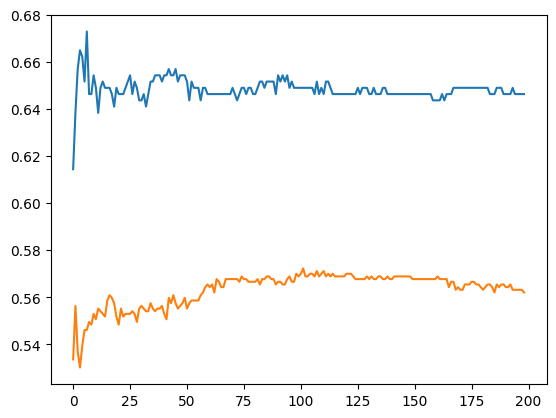

In [21]:
# Plot Results
plt.plot(train_scores)
plt.plot(test_scores)
plt.show()

#### Performance Evaluation - Confusion Matrix

In [ ]:
# training confusion matrix
cm_train = confusion_matrix(y_train, 

#### References
1. VIX: https://www.investopedia.com/terms/v/vix.asp
2. S&P500: https://www.investopedia.com/terms/s/sp500.asp
3. yfinance: https://github.com/ranaroussi/yfinance